# **Importing libs**

In [1]:
#============ Standart
import os
import warnings
import numpy as np 
import pandas as pd
from math import sqrt
from scipy.special import boxcox1p
from scipy.stats import norm, skew


#============= Viz tools
import seaborn as sns
import matplotlib.pyplot as plt


#============= Models and tests
from sklearn.svm import SVC
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.impute import SimpleImputer
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score, log_loss
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis


warnings.filterwarnings('ignore')

# **Importing and shaping the data**

In [2]:
train = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
test = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')
y_val = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv')

In [3]:
ID_test = test['Id'] # Saving ID to test accuracy later
y_train = train['SalePrice'] # Saving target for training later

train.drop('Id', inplace=True, axis=1)
test.drop('Id', inplace=True, axis=1)


full_data = pd.concat([train, test])
full_data.drop('SalePrice', inplace=True, axis=1)

full_data.shape

(2919, 79)

# **Defining which features i'll use**

* **MSZoning**: Identifies the general zoning classification of the sale.
* **LotArea**: Lot size in square feet
* **Street**: Type of road access to property
* **LandContour**: Flatness of the property
* **LotConfig**: Lot configuration
* **OverallQual**: Rates the overall material and finish of the house
* **OverallCond**: Rates the overall condition of the house
* **YearBuilt**: Original construction date
* **YearRemodAdd**: Remodel date (same as construction date if no remodeling or additions)
* **FullBath**: Full bathrooms above grade
* **1stFlrSF**: First Floor square feet
* **2ndFlrSF**: Second floor square feet
* **GrLivArea**: Above grade (ground) living area square feet
* **GarageArea**: Size of garage in square feet
* **TotRmsAbvGrd**: Total rooms above grade (does not include bathrooms)

<AxesSubplot:>

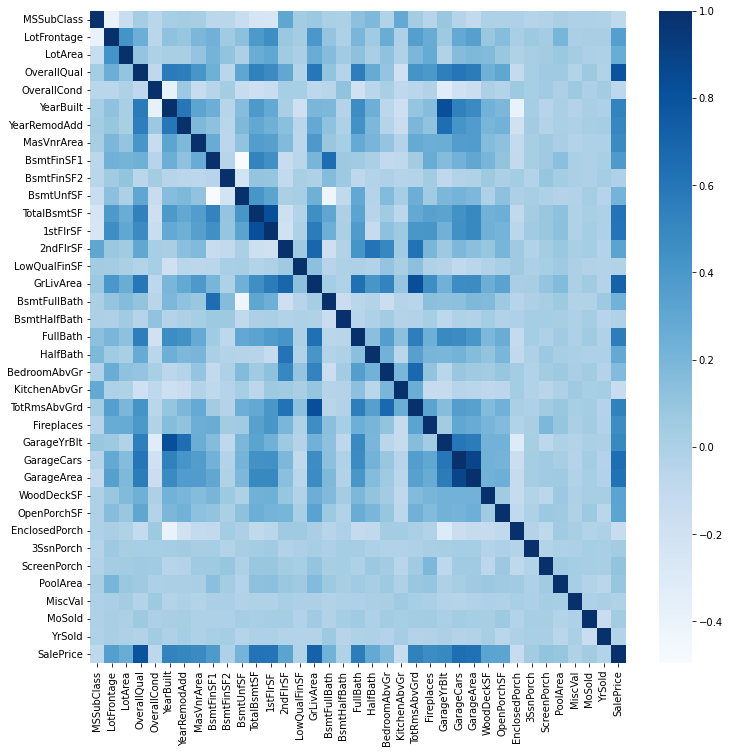

In [4]:
plt.figure(figsize= (12 , 12))
sns.heatmap(train.corr(),cmap="Blues")

In [5]:
# Defining features
features = ['MSZoning',
            'LotArea',
            'Street',
            'LandContour',
            'LotConfig',
            'OverallQual',
            'OverallCond',
            'YearBuilt',
            'YearRemodAdd',
            'FullBath',
            '1stFlrSF',
            '2ndFlrSF',
            'GrLivArea',
            'GarageArea',
            'TotRmsAbvGrd']

full_data = full_data[features]


# Separating features
num_types = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
num_features = []
cat_features = []

for col in full_data.columns:
    if full_data[col].dtype in num_types:
        num_features.append(col)
    elif full_data[col].dtype == 'object':
        cat_features.append(col)
        

full_data.isnull().sum()

MSZoning        4
LotArea         0
Street          0
LandContour     0
LotConfig       0
OverallQual     0
OverallCond     0
YearBuilt       0
YearRemodAdd    0
FullBath        0
1stFlrSF        0
2ndFlrSF        0
GrLivArea       0
GarageArea      1
TotRmsAbvGrd    0
dtype: int64

In [6]:
# Filling NA values
full_data['MSZoning'] = full_data['MSZoning'].fillna(full_data['MSZoning'].mode()[0])
full_data['GarageArea'] = full_data['GarageArea'].fillna(full_data['GarageArea'].median())


# Looking for skewness on num feats

skew = full_data[num_features].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
df_skew = pd.DataFrame({'Skew': skew})

print(df_skew.head())

lambda_skew = 0.15
for feat in skew.index:
    full_data[feat] = boxcox1p(full_data[feat], lambda_skew)


                   Skew
LotArea       12.822431
1stFlrSF       1.469604
GrLivArea      1.269358
2ndFlrSF       0.861675
TotRmsAbvGrd   0.758367


In [7]:
full_data = pd.get_dummies(full_data).reset_index(drop=True)


train = full_data[:len(train)]
test = full_data[len(train):]

Fitting 5 folds for each of 175 candidates, totalling 875 fits
Fitting 5 folds for each of 175 candidates, totalling 875 fits
Fitting 5 folds for each of 175 candidates, totalling 875 fits
Fitting 5 folds for each of 175 candidates, totalling 875 fits
Fitting 5 folds for each of 175 candidates, totalling 875 fits
Fitting 5 folds for each of 175 candidates, totalling 875 fits
Fitting 5 folds for each of 175 candidates, totalling 875 fits
Fitting 5 folds for each of 175 candidates, totalling 875 fits
Fitting 5 folds for each of 175 candidates, totalling 875 fits
Fitting 5 folds for each of 175 candidates, totalling 875 fits
Fitting 5 folds for each of 175 candidates, totalling 875 fits
Fitting 5 folds for each of 175 candidates, totalling 875 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007221 seconds.
You can set `force_row_wise=true` to remove the overhead.

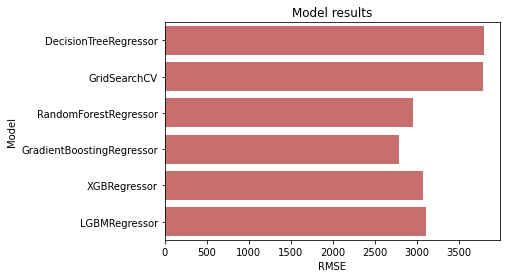

In [8]:
decision_tree_model = DecisionTreeRegressor(random_state=13)
classifiers = [
    DecisionTreeRegressor(random_state=13),
    GridSearchCV(decision_tree_model , {
    "max_depth" : [6,7,8,9,10,11,12],
    "min_samples_split": [6,7,8,9,10],
    "min_samples_leaf" : [5,7,8,9,10]
    },verbose = 1),
    RandomForestRegressor(random_state=13),
    GradientBoostingRegressor(loss='huber',random_state=13),
    XGBRegressor(objective='reg:squarederror',random_state=13),
    LGBMRegressor(objective='regression', verbose=1,random_state=13)
]

kf = KFold(n_splits=12, random_state=13, shuffle=True)

def cross_val_rmse(model, X=train , Y=y_train):
    rmse = np.sqrt(-cross_val_score(model,X, Y, scoring="neg_mean_squared_error", cv=kf))
    return (rmse)


acc_dict = {}

graph_cols = ["Model", "RMSE"]
graph = pd.DataFrame(columns=graph_cols)

X_train, X_test = full_data[:len(train)], full_data[len(train):]
y_train, y_test = y_train, y_val.iloc[:,1]



for clf in classifiers:
    name = clf.__class__.__name__
    acc = cross_val_rmse(clf).mean()
    if name in acc_dict:
        acc_dict[name] += acc
    else:
        acc_dict[name] = acc

for clf in acc_dict:
    acc_dict[clf] = acc_dict[clf] / 10.0
    new_data = pd.DataFrame([[clf, acc_dict[clf]]], columns=graph_cols)
    graph = graph.append(new_data)

plt.xlabel('RMSE')
plt.title('Model results')

sns.set_color_codes("muted")
sns.barplot(x='RMSE', y='Model', data=graph, color="r")


model = GradientBoostingRegressor(loss='huber',random_state=15)
model.fit(train, y_train)

predict = model.predict(test)
cc = sqrt(mean_squared_error(predict, y_val.iloc[:,1]))

print(cc)

In [9]:
output = pd.DataFrame({'Id': ID_test,
                       'SalePrice': predict})
output.to_csv('submission.csv', index=False)